# How to build a powerful image classificator with few images
## 1. Motivation

A very common problem found when building an image classification model (or in fact, any kind of model) is the **lack of training data**. In a lot of real-world use cases, data collection can be extremely expensive. For that reason, it is important to learn how to make the most of every piece of information that comes to our hands.

In this article we will be covering an example of a construction of an image classification model with a little amount of training images. As an outline for this article, the following topics will be covered:

* Basic architecture of a Convolutional Neural Network
* Construction of a CNN with Keras (Tensorflow)
* Train of a neural network with a data generator
* Image Generation and data augmentation techniques

The problem that we will be doing is named Cats vs Dogs, and it consists of detecting if in a photo appears a cat or a dog. In our experiment we will use only 2000 pictures, which we obtained from [Kaggle](https://www.kaggle.com/c/dogs-vs-cats/data). The original dataset has 12,500 images of cats and 12,500 images of dogs, but we will just be taking the first 1000 photos of each class. Also, we will be taking 200 additional samples from each class to validate our model.

## 2. Convolutional Neural Networks
A Convolutional Neural Network is a neural network that has one or more convolutional layers. They are mostly used for image processing and classification.

A convolution is essentially sliding a filter over the input. Intead of looking at an entire image at once, it is more effective to look at smaller pieces of the image.

![](cats-dogs.gif)

For more information about CNN, in this same blog there is an interesting [Introduction to Convolutional Neural Networks](https://datauab.github.io/mnist_example/).

## 3. Generator function
First, if we are working with images, loading the whole dataset into a single python variable *is not an option*, so we will need a generator function.

> "A generator function is like a normal python function, but it behaves as an iterator. When this generator is called it returns a value and it saves its own state, so the next time it is called it will start from the saved state."

To use a Generator function with Keras is necessary to have the images saved ina specific subdirectory format. We need a training data directory and validation data directory containing one subdirectory per image class. The directories for this problem should look like the following:

![](dir.PNG)

## 4. Image Augmentation Techniques

Image augmentation techniques are methods to artificially increase the number of images of a dataset by altering the original images with basic operations, such as rotations, zooms, translations and so on.

We will show how to use the *ImageDataGenerator* from Keras with a little example.

In [1]:
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import matplotlib.pyplot as plt
import os

Using TensorFlow backend.


In [2]:
datagen = ImageDataGenerator(
    rotation_range=50,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

Here we can see some of all the available options that we can specify for our Image generator (for more, see the [documentation](https://keras.io/preprocessing/image/#imagedatagenerator-class)).

These ones mean exactly the following:
* *rotation_range*: is a value specified in degrees that is a range for random rotations. This value can go from 0 to 180.
* *width_shift* and *height_shift*: these values represent a percentage of the total height or width of the image and they determine the range for horizontal and vertical random translations.
* *zoom_range*: it is used for randomly zoom in the pictures.
* *horizontal_flip*: when this boolean is true, half of the images generated will be flipped horizontally.

Next, we are going to read a specific image and we will show what happens after generating images from the original image.

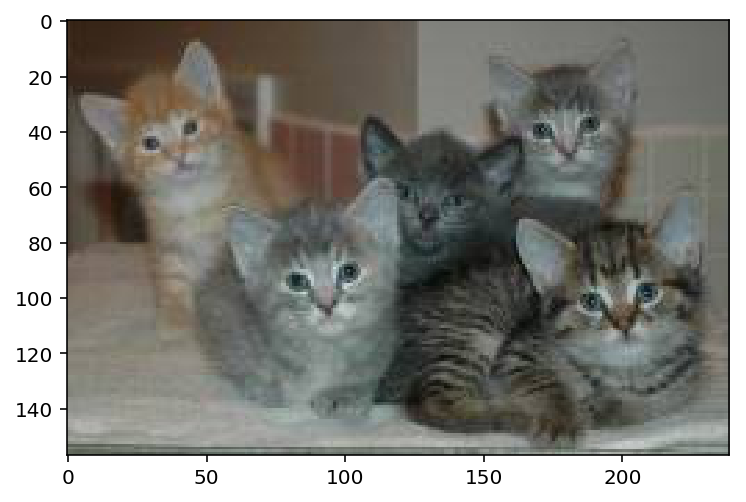

In [3]:
#Showing the original image
img = load_img("cat.172.jpg")
plt.imshow(img)
plt.show()

With the following code we will save 9 generated photos into the directory “preview”, with the name “cat” and the format “jpg”.

In [4]:
#Generating 9 images
x = img_to_array(img)
x = x.reshape((1,) + x.shape)

i = 0
for batch in datagen.flow(x, batch_size=1, save_to_dir='preview',
                          save_prefix="cat", save_format="jpg"):
    i += 1
    if i >= 9:
        break

Finally, we can show the 9 generated photos in the same plot with the following code:

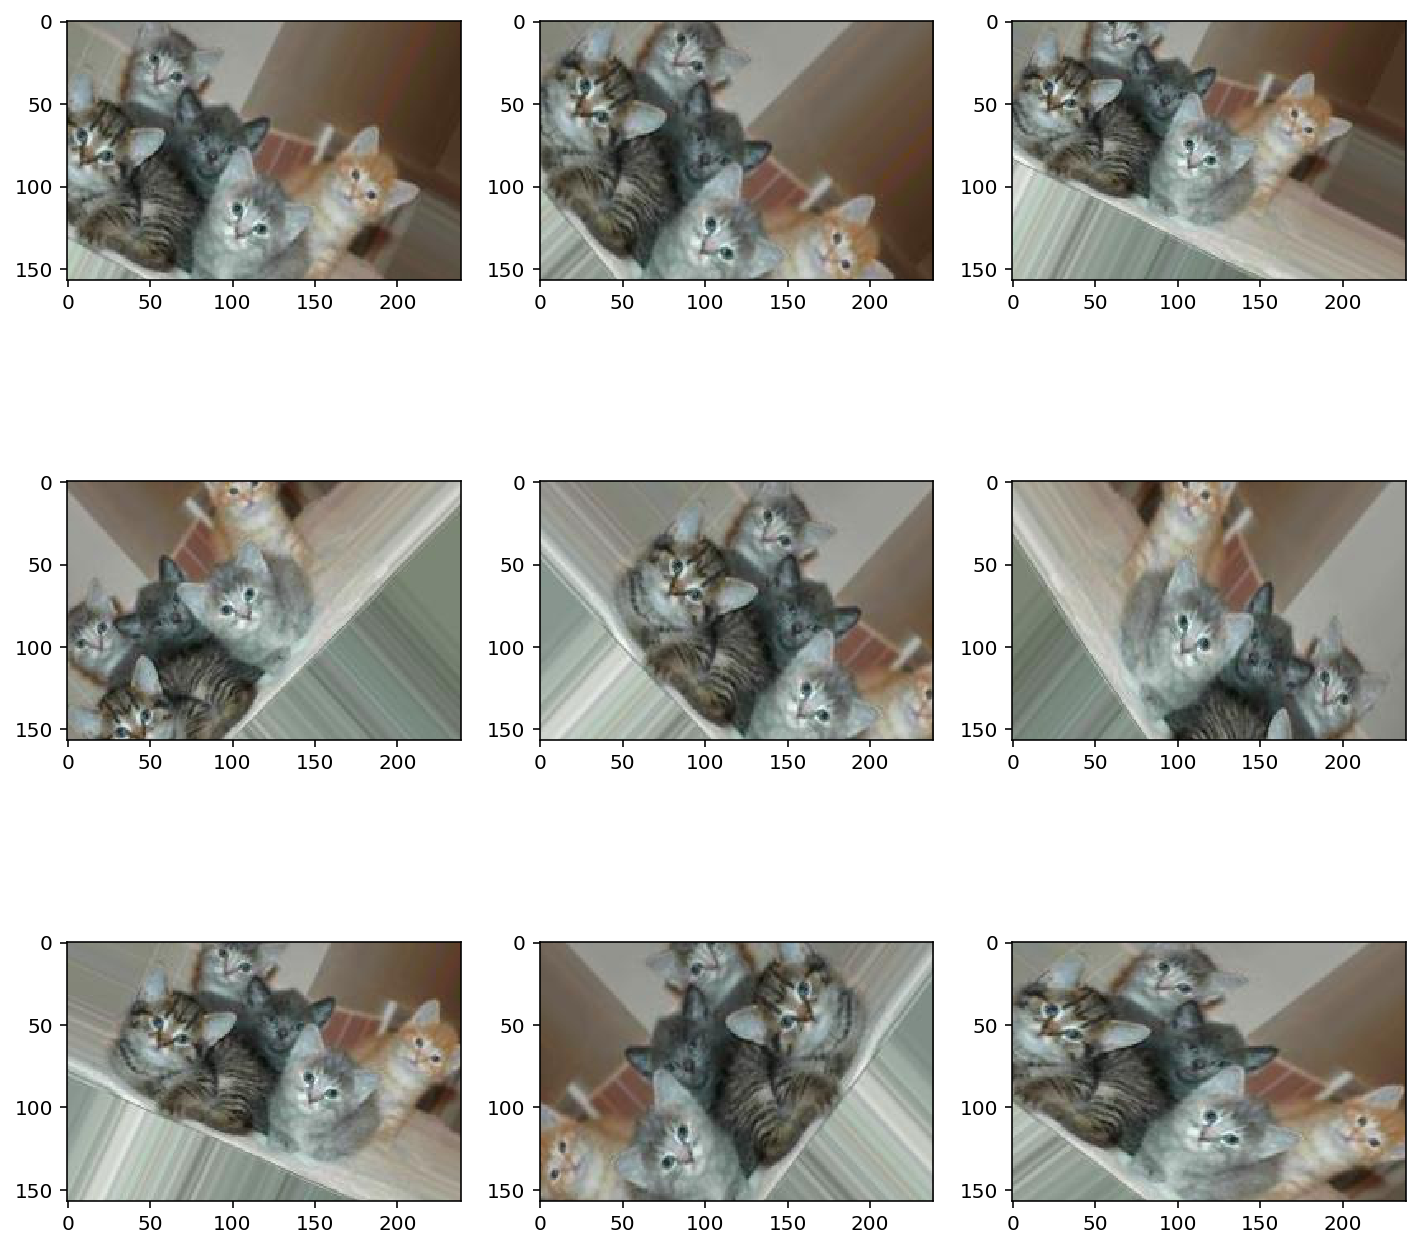

In [5]:
#Plotting the generated images
imgs = os.listdir('preview')

_, axs = plt.subplots(3, 3, figsize=(12, 12))
axs = axs.flatten()
for img, ax in zip(imgs, axs):
    img = plt.imread('preview/' + img)
    ax.imshow(img)

plt.show()

## 4. CNN Architecture

The CNN Architecture that we will use is a very simple one. We will use a very small convolutional net with few layers and few filters per layer. The following schema shows the architecture our CNN will have:

![](CNNdogs-cats.png)

Our CNN is a simple stack of 3 convolution layers with a ReLU activation and MaxPooling layers.
Let’s briefly explain some basic concepts about this CNN:
* Input Layer: the input layer represent the input image data. It will reshape the image into a single dimension array.
* Conv Layer: the convolutional layers are responsible for extracting features from the image.
* Pooling Layer: this type of layer reduce the spatial volume of input image after a convolution.
* Fully Connected Layer: this layer connects the network from a layer to another layer.
* Output Layer: in this layer we obtain the predicted values, in this case the probability of having a dog in the image.


Now we can move on the the code. The first step is to include the libraries and declare some constants for the problem:

In [6]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
import pickle

In [7]:
# dimensions of our images
img_width, img_height = 150, 150

train_data_dir = 'data/train'
validation_data_dir = 'data/validation'
nb_train_samples = 2000
nb_validation_samples = 400
epochs = 50
batch_size = 16

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

Now we can take a look to the code to declare the CNN structure:

In [8]:
#CNN MODEL
model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 47, 47, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 47, 47, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 64)        18496     
__________

In [9]:
#Compilation
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

Now that we have our CNN structure ready, we have to declare the Generator functions and the Image Generators to be able to train the net:

In [0]:
#IMAGE GENERATORS
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        'data/train',  # this is the target directory
        target_size=(150, 150),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        'data/validation',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')

And finally we can train our net. Don't forget to always save the weights after training the CNN!

In [0]:
#Training
model.fit_generator(
        train_generator,
        steps_per_epoch=2000 // batch_size,
        epochs=50,
        validation_data=validation_generator,
        validation_steps=800 // batch_size)
model.save_weights('weights.h5')

We can now fit the model and visualise the Loss and the Accuracy:

In [0]:
#Fitting the model and showing Loss and Accuracy
history = model.fit_generator(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=800//batch_size,
    steps_per_epoch=2000//batch_size
)

model.save_weights("fitted_weights.h5")

plt.figure()
plt.title("Loss")
plt.plot(history.history['loss'], color='b', label="Training loss")
plt.plot(history.history['val_loss'], color='r', label="validation loss")
plt.xticks(np.arange(1, epochs, 1))
plt.yticks(np.arange(0, 1, 0.1))
plt.legend(loc='best', shadow=True)
plt.show()
plt.close()

plt.figure()
plt.plot("Accuracy")
plt.plot(history.history['acc'], color='b', label="Training accuracy")
plt.plot(history.history['val_acc'], color='r',label="Validation accuracy")
plt.yticks(np.arange(0, 1, 0.1))
plt.xticks(np.arange(1, epochs, 1))
plt.legend(loc='best', shadow=True)
plt.show()
plt.close()

![](loss.png)

![](accuracy.png)

Now we will observe the output of the convolutional layers on a specific image:

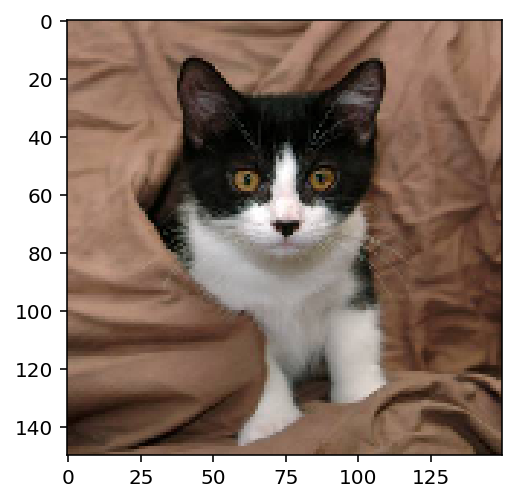

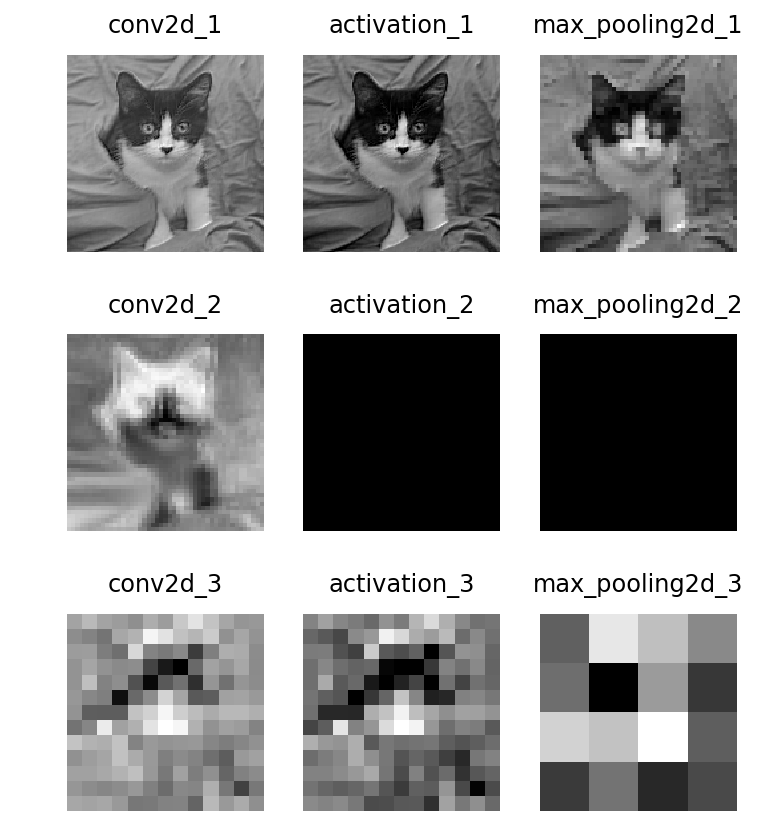

In [10]:
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

img_path = 'cat.1002.jpg'
img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.
plt.imshow(img_tensor[0])
plt.show()

layer_outputs = [layer.output for layer in model.layers[:9]]
layer_names = [layer.name for layer in model.layers[:9]]
# Extracts the outputs of the top 9 layers
activation_model = Model(inputs=model.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input

activations = activation_model.predict(img_tensor)

fig = plt.figure()
for i in range(len(activations)):
    activation = activations[i]
    ax = fig.add_subplot(3, 3, i+1)
    ax.set_title(layer_names[i])
    ax.matshow(activation[0, :, :, 0], cmap='gray')
    plt.subplots_adjust(top=1.5)
    ax.axis("off")
plt.show()

Let's predict 2 test images to see of the model is working correctly with the test data:

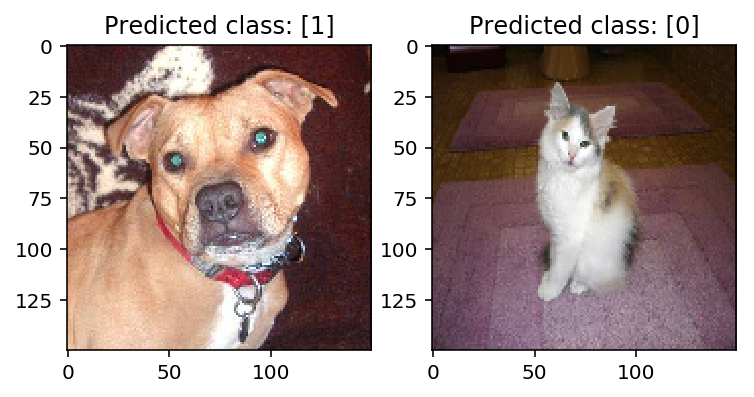

In [11]:
# Predicting 2 images
img_dog = image.load_img('2.jpg', target_size=(img_width, img_height))
x = image.img_to_array(img_dog)
x = np.expand_dims(x, axis=0)

img_cat = image.load_img('10.jpg', target_size=(img_width, img_height))
y = image.img_to_array(img_cat)
y = np.expand_dims(y, axis=0)

model.load_weights('first_try.h5')
images = np.vstack([x, y])
classes = model.predict_classes(images, batch_size=10)

plt.figure()
plt.subplot(121)
plt.title("Predicted class: " + str(classes[0]))
plt.imshow(img_dog)

plt.subplot(122)
plt.title("Predicted class: " + str(classes[1]))
plt.imshow(img_cat)
plt.show()

As we can see, the model is working right: 1 means dog and 0 means cat.

Finally, we want to discover which are the characteristics that the model indentify as cat features or dog features. To understand that, we will show 10 random good predicted images and 10 random bad predicted images of each class:

In [0]:
predictions = model.predict_generator(validation_generator, nb_validation_samples // batch_size)

pickle_out = open("predictions.pickle","wb")
pickle.dump(predictions, pickle_out)
pickle_out.close()

In [0]:
pickle_in = open("predictions.pickle","rb")
predictions = pickle.load(pickle_in)

bad_predicted_cats = []
bad_predicted_dogs = []
good_predicted_cats = []
good_predicted_dogs = []

for index, probability in enumerate(predictions):
    image_path = validation_data_dir + "/" + validation_generator.filenames[index]
    img = mpimg.imread(image_path)

    actually_cat = "cat" in image_path

    predicted_cat = False
    if probability < 0.5:
        predicted_cat = True

    if actually_cat and not predicted_cat:
        # Cat predicted as a dog
        bad_predicted_cats.append([img, probability])

    if not actually_cat and predicted_cat:
        # Dog predicted as a cat
        bad_predicted_dogs.append([img, probability])

    if actually_cat and predicted_cat:
        # Cat predicted as a car
        good_predicted_cats.append([img, probability])

    if not actually_cat and not predicted_cat:
        # Dog predicted as a dog
        good_predicted_dogs.append([img, probability])

In [0]:
n_images = 10

# Good predicted cats
fig = plt.figure()
fig.suptitle("Good predicted Cats")
for i in range(n_images):
    index = i
    img = good_predicted_cats[index][0]

    ax = fig.add_subplot(2, 5, i + 1)
    ax.set_title('cat')
    ax.axis("off")
    ax.imshow(img)

plt.show()
plt.close()

# Print incorrect predicted cat images
fig = plt.figure()
fig.suptitle("Cats predicted as Dogs")
for i in range(n_images):
    index = i + 30
    img = bad_predicted_cats[index][0]

    ax = fig.add_subplot(2, 5, i + 1)
    ax.set_title('dog')
    ax.imshow(img)
    ax.axis("off")

plt.show()
plt.close()

# Good predicted dogs
fig = plt.figure()
fig.suptitle("Good predicted Dogs")
for i in range(n_images):
    index = i
    img = good_predicted_dogs[index][0]

    ax = fig.add_subplot(2, 5, i + 1)
    ax.set_title('dog')
    ax.axis("off")
    ax.imshow(img)

plt.show()
plt.close()

# Print incorrect predicted dog images
fig = plt.figure()
fig.suptitle("Dogs predicted as Cats")
for i in range(n_images):
    index = i
    img = bad_predicted_dogs[index][0]

    ax = fig.add_subplot(2, 5, i + 1)
    ax.set_title('cat')
    ax.axis("off")
    ax.imshow(img)

plt.show()
plt.close()

![](good_cats.png)

![](bad_cats.png)

![](good_dogs.png)

![](bad_dogs.png)

From these classified images we can extract some clear features that are helping the classification model to see if the image is a cat or a dog.

In first place, we can see that the good classified cats usually appear looking directly to the camera, with a very bright eyes and with a very characteristic cat shaped ears.
These 3 characteristics are precisely the ones that don't appear in the bad classified cat photos. In this photos we see sideways cats, groups of cats and cats with darker eyes.

On the other hand, in the good classified dog images we can observe that dogs have a very different ear shape than cats. The ear shape and the big dog body shape seem to be determinant features for the model to determine the image is a dog. In the bad classified dog images we can observe that the model fails when the dog is more little or hairy, being then more similar to a cat.

## 5. Conclusions

In this post we covered one of the most common problems when working with data: the lack of the data itself. That's the reason why in this post we learned **image augmentation techniques**, how to **build a simple CNN**, how to **fit its parameters** and finally how to **predict using the trained model**.

Some conclusions extracted in this post are:
* The model predicts very well cats when they look directly to the camera, when you can see their ears or when they have very bright eyes.
* The model fails to predict cats when they appear sideways or in group, or when they have darker eyes.
* The model predicts very well dogs when they are big and because of the very different shaped ears.
* The model fails to predict dogs when they are little or hairy.

The state of the art for this problem suggests machine classifiers can score above 80% accuracy on this task, as can be seen [here](http://xenon.stanford.edu/~pgolle/papers/dogcat.pdf). This score was beated in the Kaggle competition, since nowadays there are models with an accuracy of a 99%. These models have achieved this accuracy by using more training data not provided in Kaggle.

The most popular kernel in Kaggle resolving this problem can be visited [here](https://www.kaggle.com/uysimty/keras-cnn-dog-or-cat-classification).

In our case, by using the image augmentation techniques we achieved an **accuracy of an 80%** with only **1000 training images of each class**, so we can affirm that we achieved the first state of the art only using the **7% of the available data**.